# Import preprocessed data
## Preamble

In [ ]:
import numpy as np
from src.data_methods import read_movies,read_viewers
import kagglehub
import os

# Data downloading and preprocessing

In [2]:
# Download latest version
#please ikke offentliggør min api key. 
os.environ['KAGGLE_USERNAME'] = "marcusgaleajacobsen"
os.environ['KAGGLE_KEY'] = "32a3003f52c97053841ea46c492128dc"
datapath = kagglehub.dataset_download("netflix-inc/netflix-prize-data")

In [3]:
n_lines = np.inf #number of reviews to read
datafiles = ["combined_data_1.txt"]#, "combined_data_2.txt", "combined_data_3.txt", "combined_data_4.txt"]
with_tqdm = True #set to True to see progress bar (reduce speed)
reviews_pr_user = 10 #number of reviews per user to read

movies = read_movies(datapath)
users = read_viewers(datapath, movies, datafiles = datafiles, with_tqdm= with_tqdm, n_lines=n_lines,)# reviews_pr_user=reviews_pr_user) #read only 100000 

100%|██████████| 24058263/24058263 [01:22<00:00, 292428.85it/s]


In [4]:
#trim users with less than 10 movies
not_enough_movies = [id for id,user in users.items() if user.n_watched < 200]
for user_id in not_enough_movies:
    del users[user_id]

# Compute minhash signatures
The following code computes the minhash signatures for the preprocessed data. The minhash signatures are computed using `mm3` hash functions. The signatures are stored in a dictionary where the key is the user id and the value is the minhash signature.

```python
SIG = {  
    "userid_1" : minhash_signature_1,
    "userid_2" : minhash_signature_2,
    ...
    "userid_n" : minhash_signature_n
    }
```

In [5]:
from src.similarity_methods import compute_signatures, create_buckets, get_candidates, trim_candidates
n_hashes = 20 #number of hash functions
SIG = compute_signatures(users, n_hashes, with_tqdm = True)

100%|██████████| 21045/21045 [00:44<00:00, 477.39it/s]


# Locality Sensitive Hashing (LSH)
We procced to perform Locality Sensitive Hashing (LSH) for the minhash signatures. The goal is to find similar users without comparing all pairs.

The following code splits the minhash signatures into bands of equals size. Each band for a user is hashed to a bucket id. The buckets are stored into a list of dictionaries where the key is the bucket id and the value is a list of users that hash to that bucket.

```python
buckets = [
    {
        "bucket_id_1" : ["userid_1", "userid_2", ...],
        "bucket_id_2" : ["userid_3", "userid_4", ...],
        ...
        "bucket_id_n" : ["userid_m", "userid_o", ...]
    },
    ...
    {
        "bucket_id_1" : ["userid_1", "userid_2", ...],
        "bucket_id_2" : ["userid_3", "userid_4", ...],
        ...
        "bucket_id_n" : ["userid_m", "userid_o", ...]
    }
]
```

In [6]:
b = 5 #number of bands
n_buckets = 2**16
buckets = create_buckets(SIG, bands = b, n_buckets= n_buckets)

Compute the candidate pairs by comparing the users in the same bucket. The candidate pairs are stored in a list of tuples where the first element is the user id and the second element is the user id.

```python
candidate_pairs = [
    ("userid_1", "userid_2"),
    ("userid_3", "userid_4"),
    ...
    ("userid_m", "userid_o")
]
```

In [7]:
candidates = get_candidates(buckets)

100%|██████████| 5/5 [00:01<00:00,  4.37it/s]


Get measures for future performance evaluation.

In [8]:
#binomial coefficient
from math import comb
n_candidates = len(candidates) #number of candidate pairs
n_users = len(users) #number of users
n_pairs = comb(n_users, 2) #number of possible pairs
n_pairs

221435490

### Theoretical threshold for Jaccard similarity
The Jaccard similarity threshold is computed as follows

In [9]:
r = n_hashes // b #number of rows
t = (1/b)**(1/r) #threshold for similarity computed from number of bands and rows
t #threshold for similarity

0.668740304976422

We proceed to remove all candidate pairs with a Jaccard similarity below the threshold.

In [10]:
n_removed = trim_candidates(users, candidates, threshold = t)
print(f"Removed {n_removed} from {len(candidates)} candidates")

100%|██████████| 3109415/3109415 [04:30<00:00, 11512.63it/s]

Removed 173371 from 3109415 candidates


The neighbors for the first 10 users

In [11]:
for i,user in enumerate(users.values()):
    #only the first 10 users
    if i < 10:
        print(f"User {user.id} has neighbors {user.neighbors}")

User 1488844 has neighbors defaultdict(<class 'float'>, {'1645455': 0.7793493635077794, '2316963': 0.7156398104265402, '158197': 0.6882430647291942, '398194': 0.7535014005602241, '852193': 0.7260677466863034, '1851758': 0.7730496453900709, '781610': 0.7335243553008596, '2135285': 0.6821322803553801, '1114617': 0.7996845425867508, '896927': 0.7510775862068966, '841955': 0.7668393782383419, '2307327': 0.7566666666666667, '607188': 0.7004830917874396, '2360767': 0.7561697926949654, '2512128': 0.7071339173967459, '297100': 0.7381974248927039, '2136526': 0.7994746059544658, '1036918': 0.7515060240963856, '1732841': 0.8035343035343036, '933168': 0.731357552581262, '410446': 0.7229050279329609, '1072312': 0.7669172932330827, '1096917': 0.7561904761904762, '1970957': 0.7891737891737892, '1501943': 0.8182711198428291, '301047': 0.7813504823151125, '2174151': 0.7159372419488026, '522710': 0.7696629213483146, '1862272': 0.7598152424942263, '290874': 0.7578757875787578, '1641753': 0.77540106951871

In [12]:
# #sanity check
# user1 = users["1488844"]
# user2 = users["830855"]

# print(f"{user1} has avg rating {user1.average_rating():.2f}. {user2} has average ratings {user2.average_rating():.2f}. Their similarity is {user1.similarity(user2, method = 'jaccard'):.2f}")
# intersection = set(user1.ratings.keys()).intersection(user2.ratings.keys())
# for movie_id in intersection:
#     print(f"{movies[movie_id]} was rated as {user1.ratings[movie_id]} by {user1} and {user2.ratings[movie_id]} by {user2}")

# Performance
A sanity check is performed to ensure that we can predict a user's 

In [13]:
from src.performance_metrics import prediction,prediction_error,prediction_error_all
user = users["1488844"]
for movie_id, rating in user.ratings.items():
    movie = movies[movie_id]
    pred = prediction(user, users, movie)
    print(f"User {user} rated {movie} as {rating}. Prediction is {pred:.2f}")

User User(1488844) rated Dinosaur Planet, 2003 as 3. Prediction is 3.61
User User(1488844) rated What the #$*! Do We Know!?, 2004 as 4. Prediction is 2.72
User User(1488844) rated 7 Seconds, 2005 as 2. Prediction is 2.57
User User(1488844) rated Something's Gotta Give, 2003 as 3. Prediction is 3.57
User User(1488844) rated Spitfire Grill, 1996 as 3. Prediction is 3.41
User User(1488844) rated Dragonheart, 1996 as 5. Prediction is 3.44
User User(1488844) rated I Love Lucy: Season 2, 1952 as 3. Prediction is 4.03
User User(1488844) rated Winter Kills, 1979 as 3. Prediction is 2.95
User User(1488844) rated Antarctica: IMAX, 1991 as 3. Prediction is 2.69
User User(1488844) rated Silkwood, 1983 as 3. Prediction is 3.46
User User(1488844) rated Spartan, 2004 as 3. Prediction is 3.22
User User(1488844) rated Duplex (Widescreen), 2003 as 2. Prediction is 2.78
User User(1488844) rated Rambo: First Blood Part II, 1985 as 3. Prediction is 3.23
User User(1488844) rated The Game, 1997 as 5. Predict

In [14]:
errors = prediction_error_all(users,movies)

100%|██████████| 21045/21045 [11:33<00:00, 30.35it/s] 


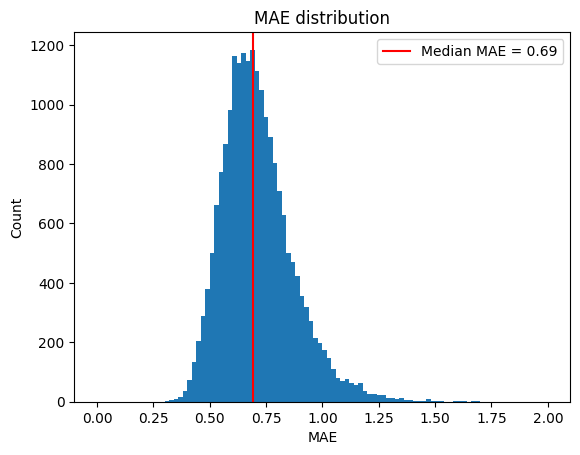

In [15]:
#Compute histogram of RMSEs
import matplotlib.pyplot as plt
plt.hist(list(errors.values()), bins = 100, range = (0,2))
#add median error
median_error = np.median(list(errors.values()))
plt.axvline(median_error, color = "red", label = f"Median MAE = {median_error:.2f}")
plt.legend()
plt.xlabel("MAE")
plt.ylabel("Count")
plt.title("MAE distribution")
#parent directory
plt.savefig("MAE.png", dpi = 600)
plt.show()